In [11]:
import sys
sys.path.append("..")

from libs.InteractivePitchUI import *
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *
from libs.convex_hull import *
from libs.alpha_shape import *
from libs.weight_generator import *
from libs.similar_movement import *

In [12]:
import glob
import os

# Load ground truth files
ground_truth_files = sorted(glob.glob('ground_truths/*.csv'))
situations_list = [pd.read_csv(file, index_col=0) for file in ground_truth_files]

# Load prediction files grouped by situation
prediction_files = sorted(glob.glob('predictions/**/*ground_truth.csv', recursive=True))
grouped_predictions = {}
for file in prediction_files:
    situation_name = '_'.join(os.path.basename(file).split('_')[:-3])
    if situation_name not in grouped_predictions:
        grouped_predictions[situation_name] = []
    grouped_predictions[situation_name].append(pd.read_csv(file, index_col=0))

print(grouped_predictions.keys())

# Merge all
resulting_dfs = [
    [
        # Merge on indices
        pd.merge(prediction,
            ground_truth,
            left_index=True, 
            right_index=True, 
            how='left'
        )
        for prediction in grouped_predictions[situation_name]  # Predictions for each situation
    ]
    for ground_truth, situation_name in zip(situations_list, grouped_predictions.keys())  # Iterate through the situations
]

resulting_dfs[3][0].score


dict_keys(['breakthrough-even_Denmark_England_0:46:06', 'breakthrough-even_Germany_Denmark_0:29:13', 'breakthrough-space_Denmark_England_0:30:51', 'breakthrough-wb_Denmark_Serbia_0:17:18', 'cross-from-cb_Denmark_Serbia_0:41:40'])


149808    2
353712    0
264720    0
116016    0
Name: score, dtype: int64

1.0
0.944847956559586
0.9639404333166532
1.0
1.0
1.0
1.0
1.0
0.6590018048024133
0.9639404333166532
1.0
0.6590018048024133
1.0
1.0
1.0
1.0
0.9197207891481876
0.6509209298071326
0.6934264036172708
0.9197207891481876
{'Situation 1': [1.0, 0.944847956559586, 0.9639404333166532, 1.0], 'Situation 2': [1.0, 1.0, 1.0, 1.0], 'Situation 3': [0.6590018048024133, 0.9639404333166532, 1.0, 0.6590018048024133], 'Situation 4': [1.0, 1.0, 1.0, 1.0], 'Situation 5': [0.9197207891481876, 0.6509209298071326, 0.6934264036172708, 0.9197207891481876]}


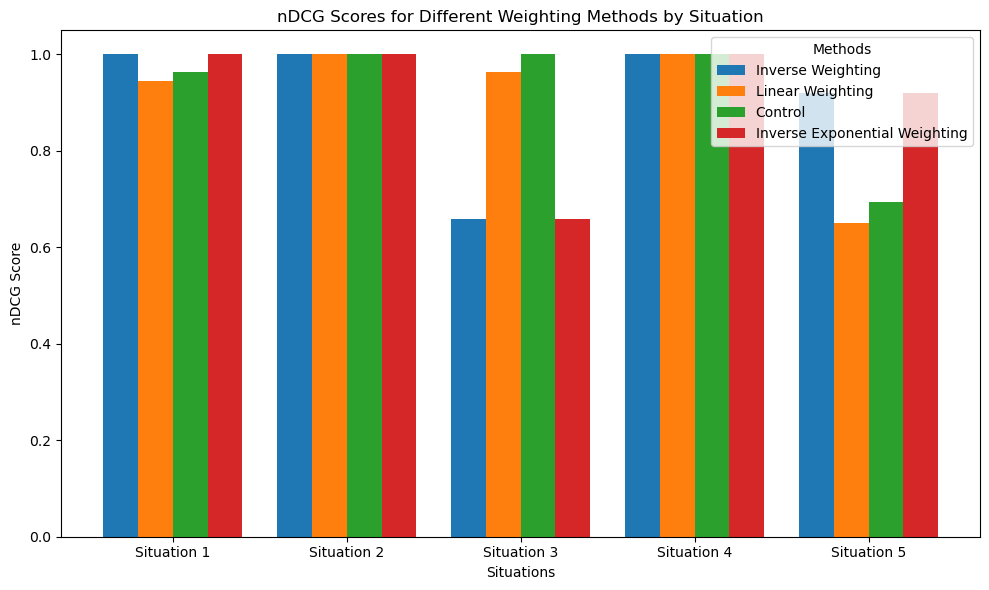

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate nDCG
def calculate_ndcg(df, score_column, k=None):
    if k is None:
        k = len(df)

    # Extract relevance scores (i.e., the score column values)
    scores = df[score_column].values[:k]

    # Compute DCG (Discounted Cumulative Gain)
    dcg = np.sum((2**scores - 1) / np.log2(np.arange(2, k + 2)))

    # Compute IDCG (Ideal DCG)
    sorted_scores = np.sort(scores)[::-1]  # Sort in descending order
    idcg = np.sum((2**sorted_scores - 1) / np.log2(np.arange(2, k + 2)))

    # Return nDCG (normalized DCG)
    return dcg / idcg if idcg > 0 else 0.0


# Function to calculate nDCG for each situation's DataFrames
def calculate_ndcg_for_situations(resulting_dfs, methods):
    ndcg_scores = {}
    
    # Iterate over each situation DataFrame list (Sit_2, Sit_3, Sit_4, etc.)
    for i, situation_df_list in enumerate(resulting_dfs):
        situation_key = f"Situation {i+1}"  # Sit_2, Sit_3, Sit_4
        ndcg_scores[situation_key] = []
        
        # Iterate over each method (Inverse Weighting, Linear Weighting, etc.)
        for j, df in enumerate(situation_df_list):
            print(calculate_ndcg(df, score_column='score'))
            ndcg_scores[situation_key].append(calculate_ndcg(df, score_column='score'))  # Assuming the scores are in 'score' column
    
    return ndcg_scores

# Define the methods
methods = ["Inverse Weighting", "Linear Weighting", "Control", "Inverse Exponential Weighting"]

# Calculate nDCG scores for all situations
ndcg_scores = calculate_ndcg_for_situations(resulting_dfs, methods)

# Print the nDCG scores to verify the calculation
print(ndcg_scores)

# Now, let's plot the results

# Prepare data for plotting
situations = list(ndcg_scores.keys())  # The situations (e.g., Sit_2, Sit_3, Sit_4)
scores = np.array([ndcg_scores[situation] for situation in situations])  # The nDCG scores for each situation

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each situation's nDCG scores (grouped by method)
width = 0.2  # Bar width for grouped bars
x = np.arange(len(situations))  # x-axis positions for each situation
for i, method_scores in enumerate(scores.T):  # Transpose to get each method's scores for plotting
    ax.bar(x + i * width, method_scores, width=width, label=methods[i])

# Customize the plot
ax.set_xlabel('Situations')
ax.set_ylabel('nDCG Score')
ax.set_title('nDCG Scores for Different Weighting Methods by Situation')
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(situations)
ax.legend(title='Methods')

# Show the plot
plt.tight_layout()
plt.savefig("../weighting_eval.png")
plt.show()



{'Sit_2': [1.0, 0.944847956559586, 0.9639404333166532, 1.0], 'Sit_3': [1.0, 1.0, 1.0, 1.0], 'Sit_4': [0.6590018048024133, 0.9639404333166532, 1.0, 0.6590018048024133], 'Sit_5': [1.0, 1.0, 1.0, 1.0], 'Sit_6': [0.9197207891481876, 0.6509209298071326, 0.6934264036172708, 0.9197207891481876]}


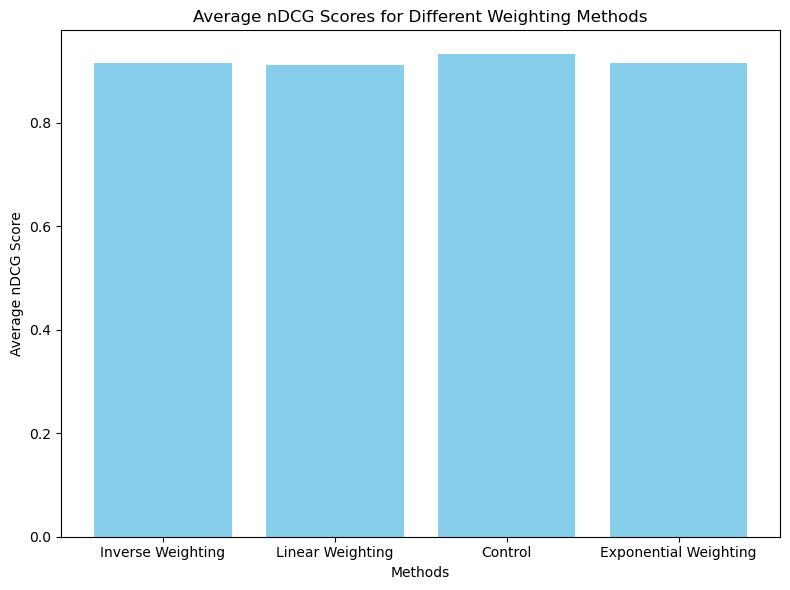

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate nDCG
def calculate_ndcg(df, score_column, k=None):
    if k is None:
        k = len(df)

    # Extract relevance scores (i.e., the score column values)
    scores = df[score_column].values[:k]

    # Compute DCG (Discounted Cumulative Gain)
    dcg = np.sum((2**scores - 1) / np.log2(np.arange(2, k + 2)))

    # Compute IDCG (Ideal DCG)
    sorted_scores = np.sort(scores)[::-1]  # Sort in descending order
    idcg = np.sum((2**sorted_scores - 1) / np.log2(np.arange(2, k + 2)))

    # Return nDCG (normalized DCG)
    return dcg / idcg if idcg > 0 else 0.0


# Function to calculate nDCG for each situation's DataFrames
def calculate_ndcg_for_situations(resulting_dfs, methods):
    ndcg_scores = {}
    
    # Iterate over each situation DataFrame list (Sit_2, Sit_3, Sit_4, etc.)
    for i, situation_df_list in enumerate(resulting_dfs):
        situation_key = f"Sit_{i + 2}"  # Sit_2, Sit_3, Sit_4
        ndcg_scores[situation_key] = []
        
        # Iterate over each method (Inverse Weighting, Linear Weighting, etc.)
        for j, df in enumerate(situation_df_list):
            ndcg_scores[situation_key].append(calculate_ndcg(df, score_column='score'))  # Assuming the scores are in 'score' column
    
    return ndcg_scores

# Define the methods
methods = ["Inverse Weighting", "Linear Weighting", "Control", "Exponential Weighting"]

# Calculate nDCG scores for all situations
ndcg_scores = calculate_ndcg_for_situations(resulting_dfs, methods)

# Print the nDCG scores to verify the calculation
print(ndcg_scores)

# Now, let's calculate the averages for each method across all situations
averages = {method: [] for method in methods}
for i, method in enumerate(methods):
    method_scores = []
    for situation in ndcg_scores.values():
        # Find the index of the method in each situation and get the score
        method_scores.append(situation[i])
    averages[method] = np.mean(method_scores)  # Average across situations

# Prepare data for plotting the averages
methods_avg = list(averages.keys())  # Methods (e.g., Inverse Weighting, Linear Weighting, etc.)
avg_scores = list(averages.values())  # Average nDCG scores for each method

# Create a plot for the averages
fig, ax = plt.subplots(figsize=(8, 6))

# Plot average nDCG scores for each method
ax.bar(methods_avg, avg_scores, color='skyblue')

# Customize the plot
ax.set_xlabel('Methods')
ax.set_ylabel('Average nDCG Score')
ax.set_title('Average nDCG Scores for Different Weighting Methods')

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

# Prepare data for the table
methods_avg = list(averages.keys())  # Methods (e.g., Inverse Weighting, Linear Weighting, etc.)
avg_scores = list(averages.values())  # Average nDCG scores for each method

# Create a DataFrame for the table
avg_table = pd.DataFrame({
    'Method': methods_avg,
    'Average nDCG Score': avg_scores
})

# Display the table
print(avg_table)


                  Method  Average nDCG Score
0      Inverse Weighting            0.915745
1       Linear Weighting            0.911942
2                Control            0.931473
3  Exponential Weighting            0.915745
